In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import lightgbm as lgb
import os
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# =============================
# 1. Load test data (2022)
# =============================
df = pd.read_csv("../data/final_test_2022.csv")
TARGET_COL = "RectifHyd_MWh"

# Ensure target is numeric and drop NaNs
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
df = df.dropna(subset=[TARGET_COL])

def get_scaler():
    df = pd.read_csv("../data/train_val_2001_2021.csv")
    scaler = StandardScaler()
    scaler.fit(df[numeric_cols])
    return scaler

In [9]:

# =============================
# 2. Identify features (same as training)
# =============================
categorical_cols = ["Division_ID", "Primary Purpose", "nerc_region", "mode"]
numeric_cols = [c for c in df.columns if c not in categorical_cols + [TARGET_COL, 'year']]

# Convert numeric columns to float and fill NaNs with *test-set* median
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())

In [10]:

# =============================
# 3. Load preprocessing objects
# =============================
# NOTE: paths must match the training script (preproc/ folder)
with open("../artifacts/label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)
with open("../artifacts/scaler.pkl", "rb") as f:
    scaler = get_scaler()

# Encode categorical columns (handle unseen values → -1)
for col in categorical_cols:
    le = label_encoders[col]
    # map known categories, unknown → -1
    df[col] = df[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )

# Scale numeric columns
df[numeric_cols] = scaler.transform(df[numeric_cols])

/Users/sreelakshmijs/miniforge3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:

# =============================
# 4. Prepare torch tensors (for NN)
# =============================
X_numeric = torch.tensor(df[numeric_cols].values, dtype=torch.float32)
X_categorical = torch.tensor(df[categorical_cols].values, dtype=torch.long)
y_true_torch = torch.tensor(df[TARGET_COL].values, dtype=torch.float32).unsqueeze(1)

In [12]:
# =============================
# 5. PyTorch Dataset / DataLoader
# =============================
class DamEnergyDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = X_num
        self.X_cat = X_cat
        self.y = y
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

test_dataset = DamEnergyDataset(X_numeric, X_categorical, y_true_torch)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [15]:
# =============================
# 6. NN model definition & load
# =============================
class DamNN(nn.Module):
    def __init__(self, n_numeric, categorical_cardinalities, emb_dim=16, hidden_dim=128):
        super(DamNN, self).__init__()
        self.embeddings = nn.ModuleList(
            [nn.Embedding(card, emb_dim) for card in categorical_cardinalities]
        )
        n_emb = emb_dim * len(categorical_cardinalities)
        self.fc1 = nn.Linear(n_numeric + n_emb, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x_num, x_cat):
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat([x_num] + embs, dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

categorical_cardinalities = [len(label_encoders[col].classes_) for col in categorical_cols]
nn_model = DamNN(len(numeric_cols), categorical_cardinalities)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model.load_state_dict(torch.load("../artifacts/best_dam_model.pt", map_location=device))
nn_model = nn_model.to(device)
nn_model.eval()

DamNN(
  (embeddings): ModuleList(
    (0): Embedding(195, 16)
    (1): Embedding(10, 16)
    (2): Embedding(6, 16)
    (3): Embedding(2, 16)
  )
  (fc1): Linear(in_features=80, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [18]:
# =============================
# 7. LightGBM model load
# =============================
lgb_path = "../artifacts/best_dam_lgbm.model"
if not os.path.exists(lgb_path):
    raise FileNotFoundError(f"LightGBM model not found: {lgb_path}")
lgb_model = lgb.Booster(model_file=lgb_path)
print(f"Loaded LightGBM model (best iteration {lgb_model.best_iteration})")


Loaded LightGBM model (best iteration -1)


In [20]:
# =============================
# 8. Predictions
# =============================
# ---- NN ----
nn_preds = []
with torch.no_grad():
    for X_num_b, X_cat_b, _ in test_loader:
        X_num_b, X_cat_b = X_num_b.to(device), X_cat_b.to(device)
        nn_preds.append(nn_model(X_num_b, X_cat_b).cpu())
nn_preds = torch.cat(nn_preds).numpy().flatten()

# ---- LightGBM ----
X_lgb = df[numeric_cols + categorical_cols]                     # already scaled/encoded
lgb_preds = lgb_model.predict(X_lgb, num_iteration=lgb_model.best_iteration)

# ---- Baseline (training mean) ----
train_df = pd.read_csv("../data/train_val_2001_2021.csv")
train_df[TARGET_COL] = pd.to_numeric(train_df[TARGET_COL], errors='coerce')
train_df = train_df.dropna(subset=[TARGET_COL])
baseline_pred = train_df[TARGET_COL].mean()
baseline_preds = np.full_like(nn_preds, baseline_pred)

# Ground truth (1-D)
y_true = df[TARGET_COL].values

In [21]:
# =============================
# 9. Metric helper
# =============================
def metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:12} | RMSE: {rmse:8.2f} | MAE: {mae:8.2f} | R²: {r2:6.3f}")
    return rmse, mae, r2


In [22]:

# =============================
# 10. Compute & display metrics
# =============================
print("\n=== 2022 Test Set Performance ===")
metrics(y_true, nn_preds,      "Neural Net")
metrics(y_true, lgb_preds,     "LightGBM")
metrics(y_true, baseline_preds,"Baseline")


=== 2022 Test Set Performance ===
Neural Net   | RMSE: 45124.52 | MAE: 10181.40 | R²:  0.694
LightGBM     | RMSE: 21589.29 | MAE:  5347.67 | R²:  0.930
Baseline     | RMSE: 81579.81 | MAE: 23711.25 | R²: -0.000


(np.float64(81579.8093344046), 23711.250233986608, -0.000181455517680007)

In [23]:
# =============================
# 11. Paired t-tests (absolute errors)
# =============================
def paired_test(err_a, err_b, name_a, name_b):
    t, p = ttest_rel(err_a, err_b)
    print(f"\nPaired t-test [{name_a} vs {name_b}]: t = {t:6.3f}, p = {p:.2e}")
    if p < 0.05:
        print("   → Statistically significant difference (p < 0.05)")
    else:
        print("   → No significant difference (p ≥ 0.05)")

nn_err   = np.abs(y_true - nn_preds)
lgb_err  = np.abs(y_true - lgb_preds)
base_err = np.abs(y_true - baseline_preds)

paired_test(base_err, nn_err,   "Baseline", "Neural Net")
paired_test(base_err, lgb_err,  "Baseline", "LightGBM")
paired_test(nn_err,   lgb_err,  "Neural Net", "LightGBM")


Paired t-test [Baseline vs Neural Net]: t = 36.494, p = 1.23e-278
   → Statistically significant difference (p < 0.05)

Paired t-test [Baseline vs LightGBM]: t = 32.959, p = 1.61e-229
   → Statistically significant difference (p < 0.05)

Paired t-test [Neural Net vs LightGBM]: t = 17.291, p = 2.67e-66
   → Statistically significant difference (p < 0.05)


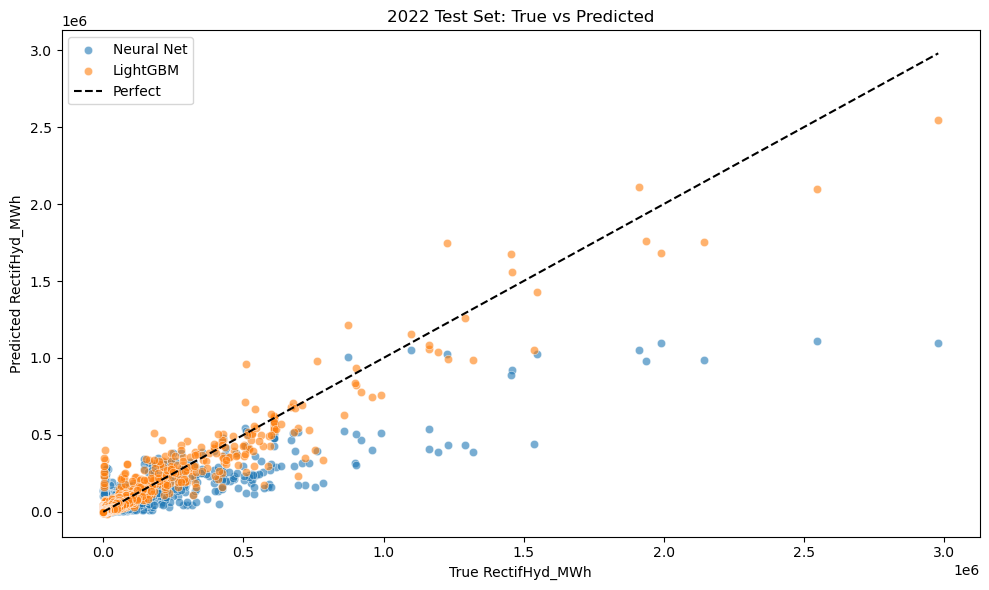

In [24]:
# =============================
# 12. (Optional) Visual comparison
# =============================
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true, y=nn_preds,  label="Neural Net", alpha=0.6)
sns.scatterplot(x=y_true, y=lgb_preds, label="LightGBM",   alpha=0.6)
sns.lineplot(x=y_true, y=y_true, color="black", linestyle="--", label="Perfect")
plt.xlabel("True RectifHyd_MWh")
plt.ylabel("Predicted RectifHyd_MWh")
plt.title("2022 Test Set: True vs Predicted")
plt.legend()
plt.tight_layout()
plt.savefig("test_predictions_comparison.png")
plt.show()